In [169]:
from numba import njit
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp # Besserer Integrator
from itertools import product

In [287]:
l = 1
beta0 = 0.5 #days^-1
gamma = 0.1 #days^-1
nu = 1/100 #days^-1
T_range = [40,60] #days
p_base_range = (0.25, 0.3)

p_cap = 1e-3
epsilon = 1e-4
s = 0. # seasonal forcing
omega = 2 * np.pi / 360 #days⁻1

maxVax = 0.01 # Von N0 können pro tag geimpft werden

p_vax = 1000 # Anteil der Leute, die angst haben und sich deswegen Impfen lassen wollen
mu_im = 1/14 #1/days


T = np.linspace(T_range[0], T_range[1], num=l)
p_base = np.linspace(p_base_range[0], p_base_range[1], num=l)
params = np.array(list(product(T, p_base))).T
T = params[0]
p_base = params[1]


In [288]:
@njit
def P(H):
    return p_base + (1-p_base)/p_cap * epsilon * np.log(1+np.exp(1/epsilon * (p_cap - H)))

@njit
def vax(H):
    return (1- np.exp(-p_vax*H))* maxVax

@njit
def Gamma(t):
    return 1+ s* np.cos(omega*t)

def odes(t, p, T, p_base):
    S = p[:l*l]
    V = p[l*l:2*l*l]
    V1 = p[2*l*l:3*l*l]
    I = p[3*l*l:4*l*l]
    H_1 = p[4*l*l:5*l*l]
    H = p[5*l*l:6*l*l]
    R = p[6*l*l:7*l*l]
    #R = 1-S-I -V - V1
    
    dS = - beta0 * P(H) * Gamma(t) * I * S + nu * (R+V) - vax(H) * S
    dV =  V1 * mu_im - nu * V
    dV1 = vax(H) * S - V1 * mu_im - beta0 * P(H) * Gamma(t) * I * V1 #TODO die hier muessen noch infiziert werden
    
    dI = beta0 * P(H) * Gamma(t) * I * (S+V1) - gamma * I 
    dR = gamma*I - nu*R
    dH_1 = 2/T * (I - H_1)
    dH = 2/T * (H_1 - H)
    
    return np.concatenate((dS,dV, dV1, dI,dH_1, dH, dR))

In [289]:
I0 = 1e-4 * np.ones(l*l)
S0 = (1-I0)
H_10 = 0 * np.ones(l*l)
H0 = 0 * np.ones(l*l)
V0 = 0. *np.ones(l*l)
V10=0 *np.ones(l*l)
R0 = np.zeros(l**2)
p0 = np.concatenate((S0, V0, V10, I0, H_10, H0, R0))
print(len(p0))

7


In [294]:
maxdt = 1
sol = solve_ivp(odes, (0,5000), p0, max_step=maxdt, args=(T,p_base))


In [295]:
p = sol.y
t = sol.t

S = p[:l*l]
V = p[l*l:2*l*l]
V1 = p[2*l*l:3*l*l]
I = p[3*l*l:4*l*l]
H_1 = p[4*l*l:5*l*l]
H = p[5*l*l:6*l*l]
R = p[6*l*l:7*l*l]

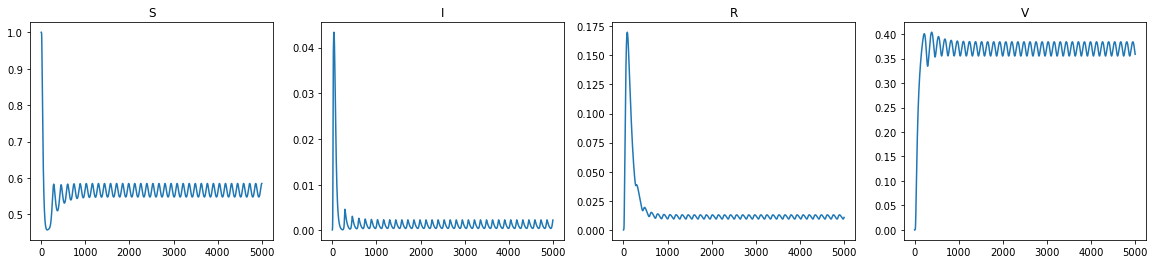

In [296]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))

plt.subplot(1,4,1)
plt.title("S")
plt.plot(t, S[0])
plt.subplot(1,4,2)
plt.title("I")
plt.plot(t, I[0])
plt.subplot(1,4,3)
plt.title("R")
plt.plot(t, R[0])
plt.subplot(1,4,4)
plt.title("V")
plt.plot(t, V[0])
plt.show()

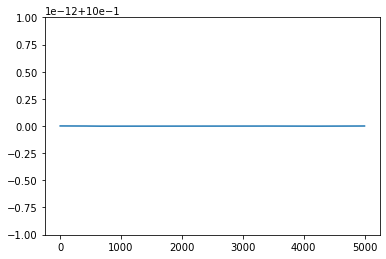

In [297]:
plt.plot(t, S[0]+I[0]+V1[0]+V[0]+R[0])